# Tonality
This is the notebook used to create the formality classifier for tonality. It uses the [Pavlick Formality Scores](https://www.cs.rochester.edu/~tetreaul/pavlick-tetreault-formality-tacl2015.pdf) dataset, downloaded from [Huggingface](https://huggingface.co/datasets/osyvokon/pavlick-formality-scores).

In [22]:
from huggingface_hub import notebook_login
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from torch.nn.functional import cross_entropy

import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [23]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Creating labels

In [24]:
formality = load_dataset("csv", 
                         data_files={"train": "../data/train.csv", "test": "../data/test.csv"})

Using custom data configuration default-502b3e36548ffb76
Reusing dataset csv (/Users/isaacaderogba/.cache/huggingface/datasets/csv/default-502b3e36548ffb76/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/2 [00:00<?, ?it/s]

In [25]:
formality.set_format(type="pandas")

train = formality["train"][:]
test = formality["test"][:]

In [26]:
def create_label(row):
    if row["avg_score"] >= 0:
        return 1
    else:
        return 0

In [27]:
train["label"] = train.apply(create_label, axis=1)
test["label"] = test.apply(create_label, axis=1)

## Visualizing length

In [28]:
def plot_words_per_sentence(df, title):
    df["word_count"] = df["sentence"].str.split().apply(len)
    df.boxplot("word_count", by="label", grid=False, showfliers=False, color="black")
    plt.suptitle("")
    plt.xlabel("Label")
    plt.ylabel("Word Count")
    plt.title(title)
    plt.show()

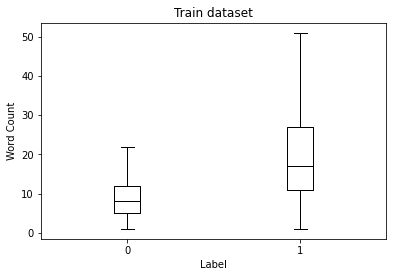

In [29]:
plot_words_per_sentence(train, "Train dataset")

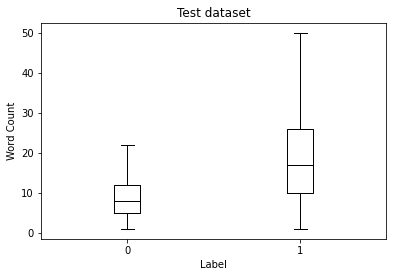

In [30]:
plot_words_per_sentence(test, "Test dataset")

In [31]:
formality.reset_format()

def create_label(batch):
    if batch["avg_score"] >= 0:
        return {"label": 1}
    else:
        return {"label": 0}
    
formality = formality.map(create_label)

Loading cached processed dataset at /Users/isaacaderogba/.cache/huggingface/datasets/csv/default-502b3e36548ffb76/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-a226518a94748cc8.arrow
Loading cached processed dataset at /Users/isaacaderogba/.cache/huggingface/datasets/csv/default-502b3e36548ffb76/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-be54dc399a65b62d.arrow


## Tokenization

In [32]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [33]:
def tokenize(batch):
    return tokenizer(batch["sentence"], padding=True, truncation=True)

In [34]:
formality_encoded = formality.map(tokenize, batched=True, batch_size=None)

Loading cached processed dataset at /Users/isaacaderogba/.cache/huggingface/datasets/csv/default-502b3e36548ffb76/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-ba7567f11f7aebd4.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

## Training

In [42]:
notebook_login()

In [43]:
device = torch.device("mps" if  torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [44]:
formality_encoded

DatasetDict({
    train: Dataset({
        features: ['domain', 'avg_score', 'sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 9274
    })
    test: Dataset({
        features: ['domain', 'avg_score', 'sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [45]:
num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

In [46]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [53]:
batch_size = 128
logging_steps = len(formality_encoded["train"]) // batch_size
model_name = "tonality"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    log_level="error"
)

In [54]:
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [55]:
trainer = Trainer(
    model=model, 
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=formality_encoded["train"],
    eval_dataset=formality_encoded["test"]
)

/Users/isaacaderogba/Documents/tonality/notebooks/tonality is already a clone of https://huggingface.co/isaacaderogba/tonality. Make sure you pull the latest changes with `repo.git_pull()`.


In [52]:
trainer.train()

/Users/isaacaderogba/.local/share/virtualenvs/tonality-iwQzFyzq/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.431400,0.411788,0.813000,0.810668
2,0.358400,0.407090,0.822500,0.822137
3,0.314900,0.406111,0.819500,0.818697
4,0.279400,0.423232,0.824000,0.823134
5,0.253800,0.430559,0.823500,0.821812


TrainOutput(global_step=365, training_loss=0.32597968088437435, metrics={'train_runtime': 6626.4264, 'train_samples_per_second': 6.998, 'train_steps_per_second': 0.055, 'total_flos': 2039506361065200.0, 'train_loss': 0.32597968088437435, 'epoch': 5.0})

## Evaluate

In [56]:
preds_output = trainer.predict(formality_encoded["test"])

In [57]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_true = np.array(formality_encoded["test"]["label"])

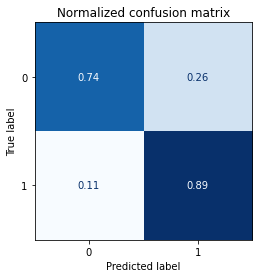

In [58]:
def plot_confusion_matrix(y_preds, y_true):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(4, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm) 
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) 
    plt.title("Normalized confusion matrix")
    plt.show()


plot_confusion_matrix(y_preds, y_true)


In [59]:
def forward_pass_with_label(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")
        
        return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}

In [61]:
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [62]:
formality_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

formality_encoded["test"] = formality_encoded["test"].map(forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/125 [00:00<?, ?ba/s]

In [63]:
formality_encoded.set_format("pandas")

cols = ["sentence", "label", "predicted_label", "loss"]
df_test = formality_encoded["test"][:][cols]
df_test["label"] = df_test["label"].apply(lambda x: "formal" if x == 1 else "casual")
df_test["predicted_label"] = df_test["predicted_label"].apply(lambda x: "formal" if x == 1 else "casual")

In [64]:
pd.set_option('display.max_colwidth', None)
df_test.sort_values("loss", ascending=False).head(10)

,sentence,label,predicted_label,loss
541,"""How slow everybody learns in a war. Nobody knows anything about a war until it begins. Just two years before, the Polish air force had been blown to hell on the ground. The French caught it the following spring. In spite of that, the same things happened to our planes at Pearl Harbor. And yet two days later, in spite of all of it, the Japs catch our air corps on Luzon with its pants down. Only that wasn't the end. Months later, on my way out through Australia, I pass a big American field, and there they are, bombers and fighters parked in orderly rows, wing tip to wing tip. 'Hell,' they told me, 'The Japs are hundreds of miles away.' Except that's where they're always supposed to be when they catch you with your pants down, and I thought to myself, Jesus Christ, won't these guys ever learn?""",formal,casual,2.926164
1110,"""On this day, he had gotten in a shipment of about eight cars - a woody, a hot rod, some car from the '20s, a DeLorean. We had business to do, so what we did was get in the woody and drive this set route he always took. He drove and we talked business on the way out, then talked about the car on the way back. Then we got in another car and did the same thing.""",formal,casual,1.445995
1293,"It seem to me, that calling the case worker who placed the girl with a co - worker who is charging this girl rent plus is liking asking the ""wolf to watch the hen house!"" I was so baffled by the response, that I asked the person at the State Attorney's office if there was anyone who looked out for children in these situations and the answer I received was ""I don't know.",formal,casual,1.431170
1031,"""There's nothing like sneaking up, and taking down a guy, and getting that notice that you have the Master Ninja trophy. It means you have improved, you are continuing to master the game, and we are recognizing that. It's not just 'Oh, here's another guy to kill.' It's 'Here's a guy who matters in a larger context. And when I defeat him, that will be recognized.' It's a solid way of rewarding and reinforcing a game's action.""",formal,casual,1.394296
1622,"Sure, Levi's claiming principles as the obstacle we're facing to knowing everything he's got on the Palin family, but this 19 year-old kid from the sticks is either as innocent as he's assumed to be, or is far, far savvier than anyone could ever imagine (or at least savvy enough to listen to good advice).",formal,casual,1.326902
1914,"Raynham store manager Bert Cabral, who noted that his shop is the busiest in Massachusetts, also talked about hiring a manager from one of the big electronics chains to help improve Wal-Mart's customer service efforts.",formal,casual,1.205692
1095,"""I told them at the start of the year that we're not going to look at a whole lot of stats, but that turnover margin is a stat we're always going to pay close attention to because it does translate into wins.""",formal,casual,1.196236
1306,"""I can't believe that any independent-minded scientists would want to take it on. People will think, if you can't speak your mind and be honest about what you think, why take on the job? It might be that the council becomes unviable.""",formal,casual,1.166160
539,"If you have ever walked through a woods when it is raining, listening to the raindrops falling from the leaves, listening to the birds singing a thankful song for a fresh rain bath and the smell of the fresh, clean air blowing through the trees, you can understand why THIS is my favorite time to be in the Gardens.",formal,casual,1.147378
575,"Oliver Miles, a former ambassador to Libya, recently revealed that Mr Blair had visited the country 'a number of times' since leaving Downing Street, adding: 'He certainly has a relationship with both the leader [Gaddafi] and the leader's son.'",formal,casual,1.120326


In [65]:
df_test.sort_values("loss", ascending=True).head(10)

,sentence,label,predicted_label,loss
1740,-------------------------------------------------------------------------------- RHODE ISLAND: Illegal General Laws of Rhode Island.,casual,casual,0.176950
730,"EDITOR: The study abstract, ""Recurrence of Lupus Nephritis Following Kidney Transplantation,"" (SA-PO3076) will be presented as part of a Poster Session during the American Society of Nephrology's 42nd Annual Meeting and Scientific Exposition on Oct. 31, from 10:00 am to 12:00 pm in the Scientific Exposition Hall of the San Diego Convention Center in San Diego, CA and at a Press Briefing on Oct. 29 at 12:40 pm in Room 12.",formal,formal,0.303267
1665,"P.S. If for any reason (and I can't imagine one), you find yourself unable to appoint Mr. Verdon, I would beg you to talk with me before you make an alternate appointment.",casual,casual,0.358173
438,"It also might not be completely out of the question that some Democratic alternatives to Meek could be attracted back into the contest if it looks like Crist is going to lose the primary, although I certainly haven't heard anything to that effect.",casual,casual,0.365515
1026,"About a week ago, geohot released an update to his iPhone jailbreaking software dubbed Blackra1n RC2, and while that was all well and good for all you AT&T guys, it did leave those of us who need a baseband unlock on our iPieces wanting more.",casual,casual,0.405442
1030,"""...We took some shots early and they were doing a good job getting to us, and we just needed to settle down as an offense and get into a rhythm. We were finally able to do that.""",casual,casual,0.407299
651,"Unlike Pavlov's ""classical conditioning,"" where an existing behavior (salivating for food) is shaped by associating it with a new stimulus (ringing of a metronome), operant conditioning is the rewarding of a partial behavior or a random act that approaches the desired behavior.",casual,casual,0.412763
1982,"On a recent market day in the village of Palnar, women balancing urns of water on their heads and bare-footed, emaciated men came out of the forests to shop for vegetables, nuts or a rotting fruit fermented to produce local liquor.",casual,casual,0.417350
1312,"As you know, there is alot of older folks in your state that are going to wonder if that is how they are going to pull the pin on them, a slow death by starvation ordered by the state.",casual,casual,0.438384
263,"Of course, this is all a matter of belief, not actual statistics of returned wallets, since Gallup did this poll by phone and didn't sprinkle wallets with two hundred bucks in them around the country.",casual,casual,0.442889


## Saving

In [67]:
trainer.push_to_hub(commit_message="Complete second pass of model")

Upload file pytorch_model.bin:   0%|          | 32.0k/380M [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 3.23k/3.23k [00:00<?, ?B/s]

To https://huggingface.co/isaacaderogba/tonality
   a397cf3..2b9d443  main -> main

To https://huggingface.co/isaacaderogba/tonality
   2b9d443..f57c1e4  main -> main



'https://huggingface.co/isaacaderogba/tonality/commit/2b9d443ad9c6adb581bd22324c62c844982b7944'

In [68]:
tokenizer.push_to_hub("isaacaderogba/tonality")

/Users/isaacaderogba/.local/share/virtualenvs/tonality-iwQzFyzq/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:39: FutureWarning: Pass token='tonality' as keyword args. From version 0.8 passing these as positional arguments will result in an error
  warnings.warn(
/Users/isaacaderogba/.local/share/virtualenvs/tonality-iwQzFyzq/lib/python3.9/site-packages/huggingface_hub/hf_api.py:641: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  warnings.warn(
Cloning https://huggingface.co/isaacaderogba/tonality into local empty directory.


Download file pytorch_model.bin:   0%|          | 9.59k/380M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 3.23k/3.23k [00:00<?, ?B/s]

Clean file training_args.bin:  31%|###       | 1.00k/3.23k [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/380M [00:00<?, ?B/s]

To https://huggingface.co/isaacaderogba/tonality
   f57c1e4..eb1ecc5  main -> main



'https://huggingface.co/isaacaderogba/tonality/commit/eb1ecc51e2e7795bedb0f9e5ab11d9470418160b'

In [69]:
from transformers import pipeline

model_id = "isaacaderogba/tonality"
classifier = pipeline("text-classification", model=model_id)

In [100]:
custom_message = "Yes, I thought so too lol."
preds = classifier(custom_message, return_all_scores=True)

/Users/isaacaderogba/.local/share/virtualenvs/tonality-iwQzFyzq/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:89: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  warnings.warn(


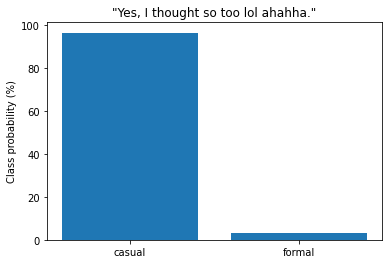

In [99]:
preds_df = pd.DataFrame(preds[0])
plt.bar(["casual", "formal"], 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_message}"')
plt.ylabel("Class probability (%)")
plt.show()

In [85]:
preds

[[{'label': 'LABEL_0', 'score': 0.26018550992012024},
  {'label': 'LABEL_1', 'score': 0.7398145198822021}]]